In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls/content/drive/MyDrive/chest_xray

/bin/bash: line 1: ls/content/drive/MyDrive/chest_xray: No such file or directory


In [ ]:
# Install Kaggle API
!pip install -q kaggle

# Upload kaggle.json (Go to: Kaggle → Account → API → Create Token)
from google.colab import files
files.upload()  # Upload kaggle.json

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shaily17","key":"74c2db037086b93d6549624e655ba7e5"}'}

In [ ]:
# Move kaggle.json to correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:21<00:00, 194MB/s]
100% 2.29G/2.29G [00:21<00:00, 113MB/s]


In [ ]:
# Unzip dataset
!unzip -q chest-xray-pneumonia.zip -d ./data

replace ./data/chest_xray/__MACOSX/._chest_xray? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls data/chest_xray/

chest_xray  __MACOSX  test  train  val


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
import numpy as np
import cv2

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 16

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    "data/chest_xray/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

val_gen = test_datagen.flow_from_directory(
    "data/chest_xray/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary"
)

test_gen = test_datagen.flow_from_directory(
    "data/chest_xray/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="binary",
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = False  # Freeze base model

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_auc",
    mode="max",
    save_best_only=True,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_auc",
    patience=5,
    mode="max",
    restore_best_weights=True
)

lr_reduce = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    verbose=1
)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=[checkpoint, early_stop, lr_reduce]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.7929 - auc: 0.7925 - loss: 0.4400
Epoch 1: val_auc improved from -inf to 0.96875, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 146s 363ms/step - accuracy: 0.7931 - auc: 0.7929 - loss: 0.4396 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.3414 - learning_rate: 1.0000e-04
Epoch 2/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9228 - auc: 0.9719 - loss: 0.1948
Epoch 2: val_auc did not improve from 0.96875
326/326 ━━━━━━━━━━━━━━━━━━━━ 103s 316ms/step - accuracy: 0.9228 - auc: 0.9719 - loss: 0.1948 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.3364 - learning_rate: 1.0000e-04
Epoch 3/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9388 - auc: 0.9777 - loss: 0.1693
Epoch 3: val_auc did not improve from 0.96875
326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 312ms/step - accuracy: 0.9387 - auc: 0.9777 - loss: 0.1693 - val_accuracy: 0.8750 - val_auc: 0.9688 - val_loss: 0.2783 - learning_rate: 1.0000e-04
Epoch 4/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9372 - auc: 0.9792 - loss: 0.1611
Epoch 4: val_auc improved from 0.96875 to 0.98438, saving m

326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 313ms/step - accuracy: 0.9373 - auc: 0.9792 - loss: 0.1611 - val_accuracy: 0.8750 - val_auc: 0.9844 - val_loss: 0.2522 - learning_rate: 1.0000e-04
Epoch 5/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9404 - auc: 0.9825 - loss: 0.1496
Epoch 5: val_auc improved from 0.98438 to 1.00000, saving model to best_model.h5


326/326 ━━━━━━━━━━━━━━━━━━━━ 102s 312ms/step - accuracy: 0.9404 - auc: 0.9825 - loss: 0.1495 - val_accuracy: 0.8750 - val_auc: 1.0000 - val_loss: 0.2590 - learning_rate: 1.0000e-04
Epoch 6/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9465 - auc: 0.9830 - loss: 0.1409
Epoch 6: val_auc did not improve from 1.00000
326/326 ━━━━━━━━━━━━━━━━━━━━ 101s 308ms/step - accuracy: 0.9465 - auc: 0.9830 - loss: 0.1409 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.2539 - learning_rate: 1.0000e-04
Epoch 7/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - accuracy: 0.9490 - auc: 0.9856 - loss: 0.1335
Epoch 7: val_auc did not improve from 1.00000

Epoch 7: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
326/326 ━━━━━━━━━━━━━━━━━━━━ 103s 314ms/step - accuracy: 0.9490 - auc: 0.9856 - loss: 0.1335 - val_accuracy: 0.8125 - val_auc: 1.0000 - val_loss: 0.2766 - learning_rate: 1.0000e-04
Epoch 8/10
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9522 - auc: 0.9

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-30]:  # Last 30 layers trainable
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss="binary_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC()]
)

history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint, early_stop, lr_reduce]
)

Epoch 1/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.9455 - auc_2: 0.9860 - loss: 0.1318

326/326 ━━━━━━━━━━━━━━━━━━━━ 152s 360ms/step - accuracy: 0.9455 - auc_2: 0.9860 - loss: 0.1318 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.1628 - learning_rate: 1.0000e-05
Epoch 2/5


/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_auc` which is not available. Available metrics are: accuracy,auc_2,loss,val_accuracy,val_auc_2,val_loss
  current = self.get_monitor_value(logs)


326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9527 - auc_2: 0.9871 - loss: 0.1271

326/326 ━━━━━━━━━━━━━━━━━━━━ 104s 317ms/step - accuracy: 0.9527 - auc_2: 0.9871 - loss: 0.1271 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.1451 - learning_rate: 1.0000e-05
Epoch 3/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9530 - auc_2: 0.9886 - loss: 0.1178

326/326 ━━━━━━━━━━━━━━━━━━━━ 103s 315ms/step - accuracy: 0.9530 - auc_2: 0.9886 - loss: 0.1178 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.1362 - learning_rate: 1.0000e-05
Epoch 4/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9595 - auc_2: 0.9899 - loss: 0.1103

326/326 ━━━━━━━━━━━━━━━━━━━━ 104s 319ms/step - accuracy: 0.9594 - auc_2: 0.9899 - loss: 0.1103 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.1441 - learning_rate: 1.0000e-05
Epoch 5/5
326/326 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9623 - auc_2: 0.9911 - loss: 0.1023

326/326 ━━━━━━━━━━━━━━━━━━━━ 103s 315ms/step - accuracy: 0.9623 - auc_2: 0.9911 - loss: 0.1023 - val_accuracy: 1.0000 - val_auc_2: 1.0000 - val_loss: 0.1117 - learning_rate: 1.0000e-05


In [ ]:
loss, acc, auc = model.evaluate(test_gen)
print("Test Accuracy:", acc)
print("Test AUC:", auc)

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - accuracy: 0.8567 - auc_2: 0.6247 - loss: 0.4316
Test Accuracy: 0.9086538553237915
Test AUC: 0.9611055850982666


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

pred = model.predict(test_gen)
pred_classes = (pred > 0.5).astype("int32")

cm = confusion_matrix(test_gen.classes, pred_classes)
print(cm)

print(classification_report(test_gen.classes, pred_classes))

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 133ms/step
[[185  49]
 [  8 382]]
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       234
           1       0.89      0.98      0.93       390

    accuracy                           0.91       624
   macro avg       0.92      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



In [ ]:
# GradCAM Function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]

    grads = tape.gradient(loss, conv_outputs)
    pooled = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


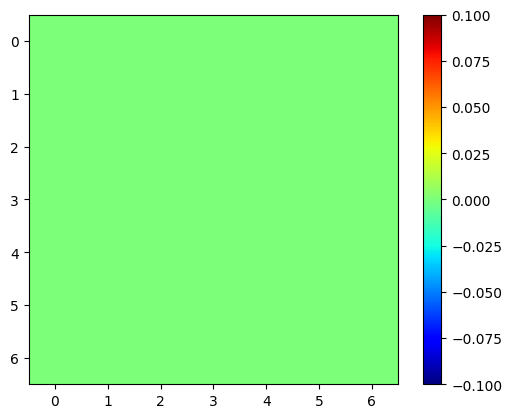

In [ ]:
# Load one test image
img_path = list(test_gen.filepaths)[0]

img = tf.keras.preprocessing.image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
img_arr = tf.keras.preprocessing.image.img_to_array(img)
img_arr = np.expand_dims(img_arr/255.0, axis=0)

# IMPORTANT: Replace correct last conv layer name
last_layer = "conv5_block16_concat"

heatmap = make_gradcam_heatmap(img_arr, model, last_layer)

# Display Heatmap
plt.imshow(heatmap, cmap='jet')
plt.colorbar()
plt.show()

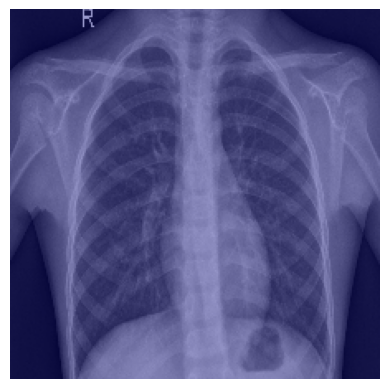

In [ ]:
original = cv2.imread(img_path)
original = cv2.resize(original, (IMG_SIZE, IMG_SIZE))

heatmap = cv2.resize(heatmap, (IMG_SIZE, IMG_SIZE))
heatmap = np.uint8(255 * heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
overlay = cv2.addWeighted(original, 0.6, heatmap, 0.4, 0)

plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()